In [23]:
# Import des librairies
import pandas as pd
from models.managers.db_manager import connect_to_bdd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


In [24]:
from matplotlib.pyplot import clf
import joblib

# Connexion à la base de données
conn = connect_to_bdd()

# Requête pour election_2022_t2 et sauvegarde dans df_election
query_election = """
    SELECT code_postal, "% Vot/Ins" AS vot_ins
    FROM election_2022_t2
"""
df_election = pd.read_sql(query_election, conn)

# Requête pour economie et sauvegarde dans df_economie
query_economie = """
    SELECT avg_1982, avg_1983, avg_1984, avg_1985, avg_1986, avg_1987, avg_1988, avg_1989,
           avg_1990, avg_1991, avg_1992, avg_1993, avg_1994, avg_1995, avg_1996, avg_1997,
           avg_1998, avg_1999, avg_2000, avg_2001, avg_2002, avg_2003, avg_2004, avg_2005,
           avg_2006, avg_2007, avg_2008, avg_2009, avg_2010, avg_2011, avg_2012, avg_2013,
           avg_2014, avg_2015, avg_2016, avg_2017, avg_2018, avg_2019, avg_2020, avg_2021,
           avg_2022, avg_2023, code_postal
    FROM economie
"""
df_economie = pd.read_sql(query_economie, conn)

# Requête pour securite et sauvegarde dans df_securite
query_securite = """
    SELECT code_postal, tauxpourcent
    FROM securite
"""
df_securite = pd.read_sql(query_securite, conn)

# Requête pour densite et sauvegarde dans df_densite
query_densite = """
    SELECT code_postal, dens_pop
    FROM demographie
"""
df_densite = pd.read_sql(query_densite, conn)

# Fermeture de la connexion
conn.close()

# Calculer la moyenne de densité de population pour chaque département
df_densite = df_densite.groupby('code_postal')['dens_pop'].mean().reset_index()

# Calculer la moyenne du taux de pourcentage de sécurité pour chaque département
df_securite = df_securite.groupby('code_postal')['tauxpourcent'].mean().reset_index()

# Fusion des dataframes sur le code_postal
df_final = df_election.merge(df_economie, on='code_postal', how='inner')
df_final = df_final.merge(df_securite, on='code_postal', how='inner')
df_final = df_final.merge(df_densite, on='code_postal', how='inner')

# Création de la variable cible
df_final['target'] = (df_final['vot_ins'] > 50).astype(int)

# Sélection des variables explicatives pouvant influencer le vote
features = df_final[
    ['dens_pop', 'avg_1982', 'avg_1983', 'avg_1984', 'avg_1985', 'avg_1986', 'avg_1987', 'avg_1988', 'avg_1989',
     'avg_1990', 'avg_1991', 'avg_1992', 'avg_1993', 'avg_1994', 'avg_1995', 'avg_1996', 'avg_1997',
     'avg_1998', 'avg_1999', 'avg_2000', 'avg_2001', 'avg_2002', 'avg_2003', 'avg_2004', 'avg_2005',
     'avg_2006', 'avg_2007', 'avg_2008', 'avg_2009', 'avg_2010', 'avg_2011', 'avg_2012', 'avg_2013',
     'avg_2014', 'avg_2015', 'avg_2016', 'avg_2017', 'avg_2018', 'avg_2019', 'avg_2020', 'avg_2021',
     'avg_2022', 'avg_2023', 'tauxpourcent']]

# Création et évaluation du modèle

# Exclure les données du département de l'Yonne (89) du jeu d'entraînement
df_train = df_final[df_final["code_postal"] != 89]

# Sélectionner uniquement les données du département de l'Yonne (89) pour les tests
df_test_yonne = df_final[df_final["code_postal"] == 89]

# Division des données en ensemble d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(features, df_final['target'], test_size=0.3, random_state=42)

# Création du modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation du modèle sur les données d'entraînement
accuracy_train = accuracy_score(y_train, model.predict(X_train))
roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

# Évaluation du modèle sur les données du 89
X_test_yonne = df_test_yonne[
    ['dens_pop', 'avg_1982', 'avg_1983', 'avg_1984', 'avg_1985', 'avg_1986', 'avg_1987', 'avg_1988', 'avg_1989',
     'avg_1990', 'avg_1991', 'avg_1992', 'avg_1993', 'avg_1994', 'avg_1995', 'avg_1996', 'avg_1997',
     'avg_1998', 'avg_1999', 'avg_2000', 'avg_2001', 'avg_2002', 'avg_2003', 'avg_2004', 'avg_2005',
     'avg_2006', 'avg_2007', 'avg_2008', 'avg_2009', 'avg_2010', 'avg_2011', 'avg_2012', 'avg_2013',
     'avg_2014', 'avg_2015', 'avg_2016', 'avg_2017', 'avg_2018', 'avg_2019', 'avg_2020', 'avg_2021',
     'avg_2022', 'avg_2023', 'tauxpourcent']]

y_test_yonne = df_test_yonne['target']
accuracy_test_yonne = accuracy_score(y_test_yonne, model.predict(X_test_yonne))
roc_auc_test_yonne = roc_auc_score(y_test_yonne, model.predict_proba(X_test_yonne)[:, 1])

print("Evaluation du modèle sur les données d'entraînement :")
print(f'Accuracy: {accuracy_train}')
#print(f'ROC AUC Score: {roc_auc_train}')

print("\nEvaluation du modèle sur les données du département 89 (Yonne) :")
print(f'Accuracy: {accuracy_test_yonne}')
#print(f'ROC AUC Score: {roc_auc_test_yonne}')

# Exporter le modèle dans un fichier pickle
path = '../pickle_files/logistic_regression_bin.pkl'
try:
    joblib.dump(clf, path)
    print("Modèle exporté avec succès dans", path)
except Exception as e:
    print("Erreur lors de l'exportation du modèle :", e)

/var/folders/9z/lnzs0dyx0k1g2nvs92hf0syr0000gn/T/ipykernel_1484/2659403668.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_election = pd.read_sql(query_election, conn)
/var/folders/9z/lnzs0dyx0k1g2nvs92hf0syr0000gn/T/ipykernel_1484/2659403668.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_economie = pd.read_sql(query_economie, conn)
/var/folders/9z/lnzs0dyx0k1g2nvs92hf0syr0000gn/T/ipykernel_1484/2659403668.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_securite = pd.read_sql(query_securite, conn)
/

Evaluation du modèle sur les données d'entraînement :
Accuracy: 0.9923562216049782

Evaluation du modèle sur les données du département 89 (Yonne) :
Accuracy: 0.9930555555555556
Modèle exporté avec succès dans ../pickle_files/logistic_regression_bin.pkl


/Users/erwanbuisson/Library/Mobile Documents/com~apple~CloudDocs/Documents/Interpreteur Python/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


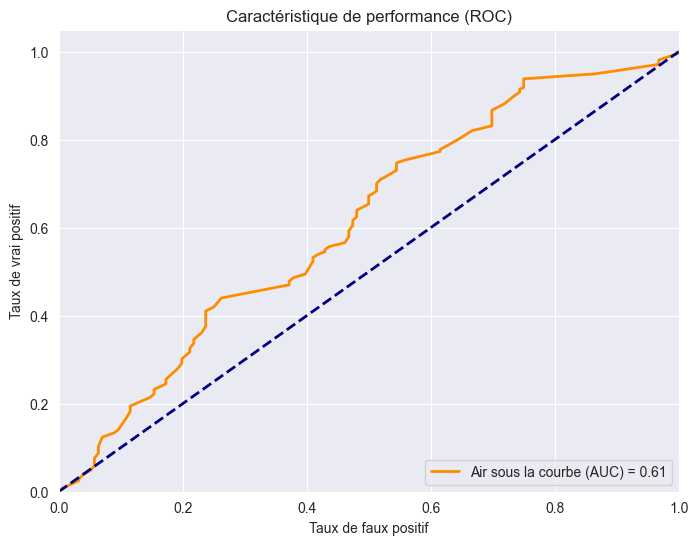

In [25]:
# Courbe ROC
y_prob = model.predict_proba(X_test)[:, 1]

# Calcul des taux pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Création de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Air sous la courbe (AUC) = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positif')
plt.ylabel('Taux de vrai positif')
plt.title('Caractéristique de performance (ROC)')
plt.legend(loc="lower right")
plt.show()

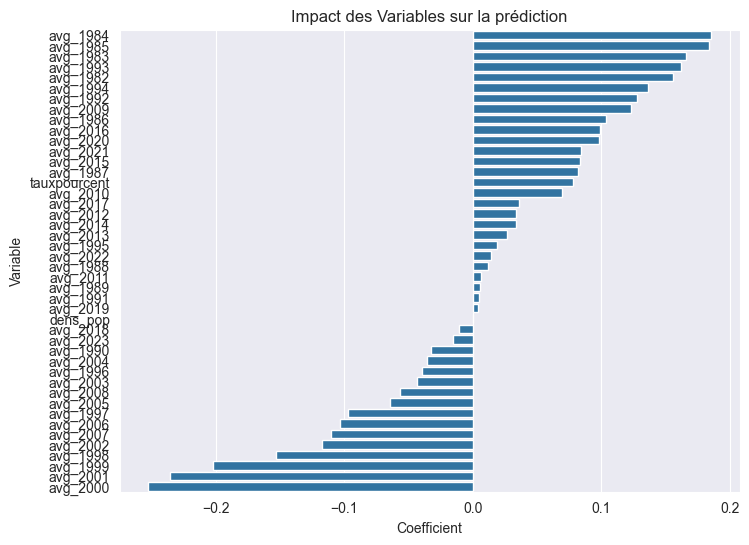

In [26]:
# Affichage des coefficients dans un diagramme à barres
coefs = pd.DataFrame({
    'Variable': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Coefficient', y='Variable', data=coefs)
plt.title('Impact des Variables sur la prédiction')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()


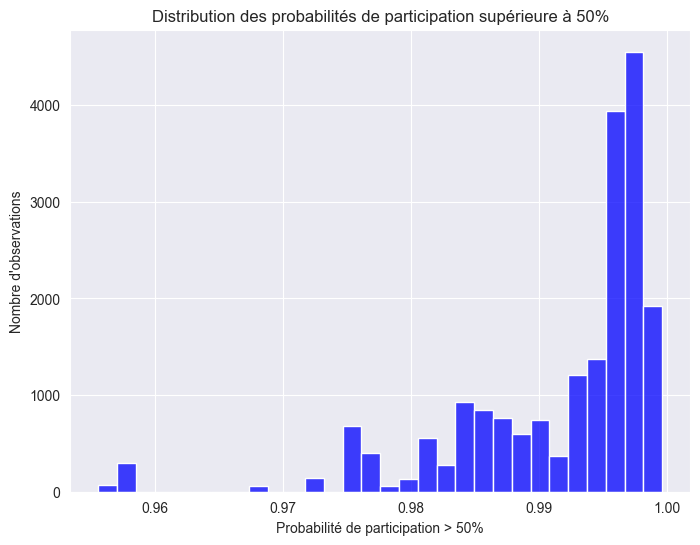

In [27]:
# Histogramme des probabilités de participation

# Prédictions de probabilité
y_prob = model.predict_proba(X_test)[:, 1]

# Création de l'histogramme
plt.figure(figsize=(8, 6))
sns.histplot(y_prob, bins=30, kde=False, color='blue')
plt.title('Distribution des probabilités de participation supérieure à 50%')
plt.xlabel('Probabilité de participation > 50%')
plt.ylabel('Nombre d\'observations')
plt.show()